In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from ds_utils.db.connectors import PivotDW

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# pd.set_option('precision', 2)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('fivethirtyeight')


# pd.option_context('display.max_rows', None, 'display.max_columns', None)

print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
# This is a query on a materialized view.  Refresh once a day.
refresh_view = False

"""
  plan_category  sales
0         180x1  38766
1         180x2    981
2         180x4  17970
3         364x1  16388
4         364x2    884
5         364x3    106
6         364x4      2
7          90x1   1906
8          90x4      2

"""

stm_query = """
    SELECT
        app_pid,
        datetime_created::DATE AS sold_date,
        date_part(YEAR, datetime_created)::INT AS sold_year,
        date_part(MONTH, datetime_created)::INT AS sold_month,
        carrier_id,
        duration_category AS plan_category,
        CASE 
            WHEN duration_category = '180x2' THEN '364x1'
            WHEN duration_category = '180x4' THEN '364x2'
            WHEN duration_category = '90x4' THEN '364x1'
            ELSE duration_category
            END AS plan_category_adj,
        split_part(duration_category, 'x', 1) AS plan_span,
        CASE 
            WHEN duration_sold < 135 THEN 90
            WHEN duration_sold BETWEEN 135 and 264 THEN 180
            WHEN duration_sold BETWEEN 265 and 546 THEN 364
            WHEN duration_sold BETWEEN 547 and 912 THEN 728
            WHEN duration_sold > 912 THEN 1092
            ELSE null END AS plan_group,
        duration_sold,
        duration_utilized,
        coalesce(termination_date, expiration_date, current_date) >= current_date AS active,
        expiration_date < current_date AS past_expiration,
        has_dental,
        has_vision,
        has_supp,
        state,
        plan_members,
        primary_age,
        (children_members > 0)::INT AS has_children,
        child_age_average
    FROM tracking.app_premium
    WHERE effective_date < current_date
        AND product_type = 'STM'
        AND duration_utilized <= duration_sold
        AND duration_utilized > 10
    ;
"""

with PivotDW() as db_context:
    
    if refresh_view:
        db_context.exec("REFRESH MATERIALIZED VIEW tracking.app_premium;")
        
    stm_df = db_context.to_df(stm_query, parse_dates='sold_date')

print(len(stm_df))
stm_df.head()


INFO:root:query: SELECT app_pid, datetime_created::DATE AS sold_date, date_pa... executed in 3.43 seconds


98800


,app_pid,sold_date,sold_year,sold_month,carrier_id,plan_category,plan_category_adj,plan_span,plan_group,duration_sold,duration_utilized,active,past_expiration,has_dental,has_vision,has_supp,state,plan_members,primary_age,has_children,child_age_average
0,211996,2019-06-30,2019,6,CLIC,180x1,180x1,180,180,180,123,False,True,1,1,0,IN,4,30.0300,1,5.1600
1,252434,2020-02-29,2020,2,CLIC,364x1,364x1,364,364,364,344,False,False,1,1,0,OH,1,36.9200,0,nan
2,318079,2020-09-03,2020,9,CLIC,364x2,364x2,364,728,728,130,True,False,1,1,0,OK,1,26.0400,0,nan
3,252055,2020-02-28,2020,2,CLIC,364x1,364x1,364,364,364,344,True,False,0,0,1,WY,1,63.5100,0,nan
4,233991,2019-11-26,2019,11,CLIC,364x1,364x1,364,364,364,364,False,True,1,1,0,GA,1,39.3000,0,nan


In [3]:
model_df = stm_df[stm_df['past_expiration'] == True].copy().reset_index(drop=True)

model_df['percent_utilized'] = model_df['duration_utilized'] / model_df['duration_sold']


model_df = model_df[[
    'app_pid', 'percent_utilized', 'plan_category', 'plan_category_adj', 'plan_group', 'duration_sold', 
    'duration_utilized', 'sold_month', 'has_dental', 'has_vision', 'has_supp', 'plan_members', 'primary_age', 
    'has_children', 'state'
]]

model_df.head()



,app_pid,percent_utilized,plan_category,plan_category_adj,plan_group,duration_sold,duration_utilized,sold_month,has_dental,has_vision,has_supp,plan_members,primary_age,has_children,state
0,211996,0.6833,180x1,180x1,180,180,123,6,1,1,0,4,30.0300,1,IN
1,233991,1.0000,364x1,364x1,364,364,364,11,1,1,0,1,39.3000,0,GA
2,307304,1.0000,90x1,90x1,90,90,90,6,1,1,0,1,41.0500,0,OR
3,245765,1.0000,364x1,364x1,364,364,364,1,1,1,0,1,44.0400,0,IN
4,247411,1.0000,364x1,364x1,364,303,303,1,1,0,0,2,30.0300,1,OH


<AxesSubplot:xlabel='plan_category_adj'>

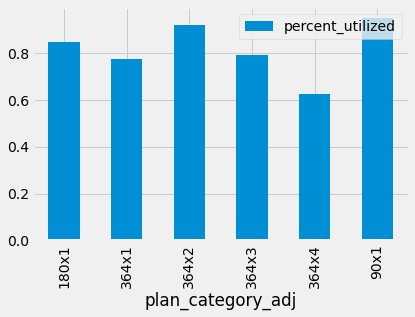

In [4]:
model_df.groupby(['plan_category_adj']).mean()[['percent_utilized']].plot.bar()

<AxesSubplot:xlabel='duration_utilized'>

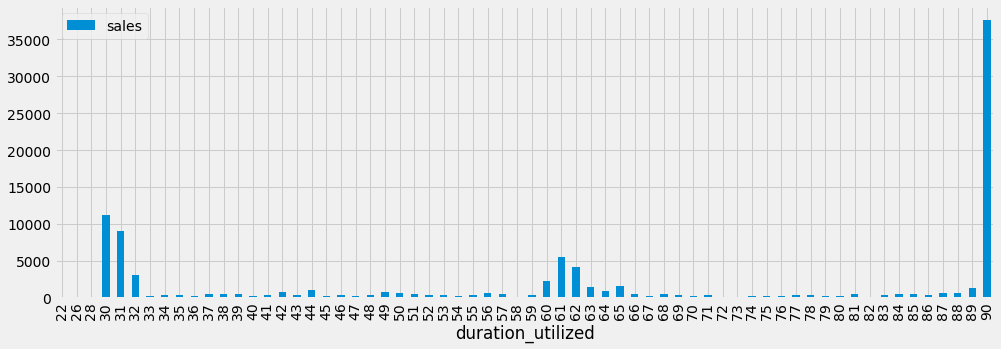

In [5]:
resamples = 100000

model_df[(model_df['plan_category'] == '90x1') & (model_df['duration_utilized'] <= 90)]\
    .sample(resamples, replace=True)\
    .groupby('duration_utilized').size().reset_index(name='sales')\
    .set_index('duration_utilized').plot.bar(figsize=(15,5))

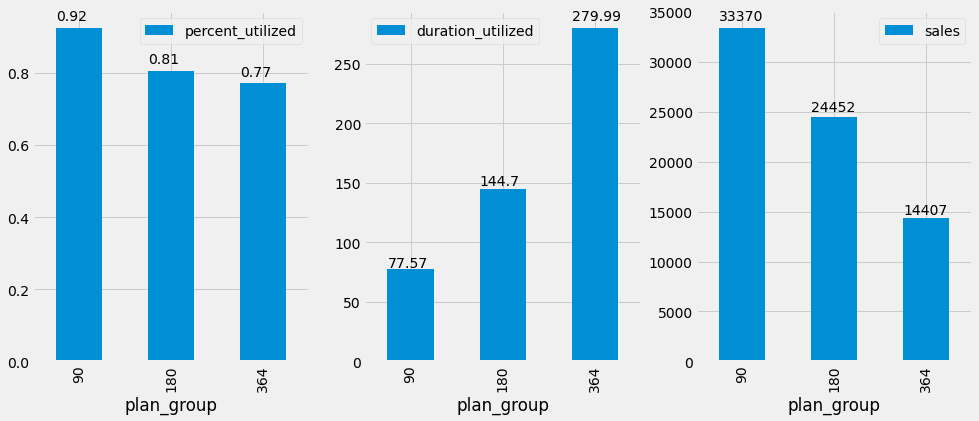

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

model_df.groupby(['plan_group']).mean()[['percent_utilized']].plot.bar(ax=ax[0])
model_df.groupby(['plan_group']).mean()[['duration_utilized']].plot.bar(ax=ax[1])
model_df.groupby(['plan_group']).size().reset_index(name='sales').plot.bar(x='plan_group', ax=ax[2])

for axs in ax:
    for p in axs.patches:
        axs.annotate(
            str(round(p.get_height(), 2)), 
            (p.get_x() * 1.00, 
             p.get_height() * 1.025)
        )
        


In [7]:
model_df[model_df['plan_category'] == '180x4']

,app_pid,percent_utilized,plan_category,plan_category_adj,plan_group,duration_sold,duration_utilized,sold_month,has_dental,has_vision,has_supp,plan_members,primary_age,has_children,state
16,237681,1.0000,180x4,364x2,364,360,360,12,0,0,1,1,50.9300,0,IA
68,212190,1.0000,180x4,364x2,90,90,90,7,1,1,0,2,57.9700,0,FL
186,114099,1.0000,180x4,364x2,90,90,90,11,0,0,0,3,55.6400,1,IL
190,160400,1.0000,180x4,364x2,90,90,90,7,0,0,0,1,54.2800,0,FL
230,115376,1.0000,180x4,364x2,90,90,90,11,0,0,0,5,53.0000,1,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72212,185963,1.0000,180x4,364x2,90,90,90,12,0,0,0,1,35.7000,0,IN
72213,134239,0.6556,180x4,364x2,90,90,59,1,0,0,0,1,58.3600,0,WI
72214,128283,1.0000,180x4,364x2,90,90,90,12,0,0,0,2,63.5400,0,GA
72216,191223,1.0000,180x4,364x2,90,90,90,1,0,0,0,1,29.9700,0,TX


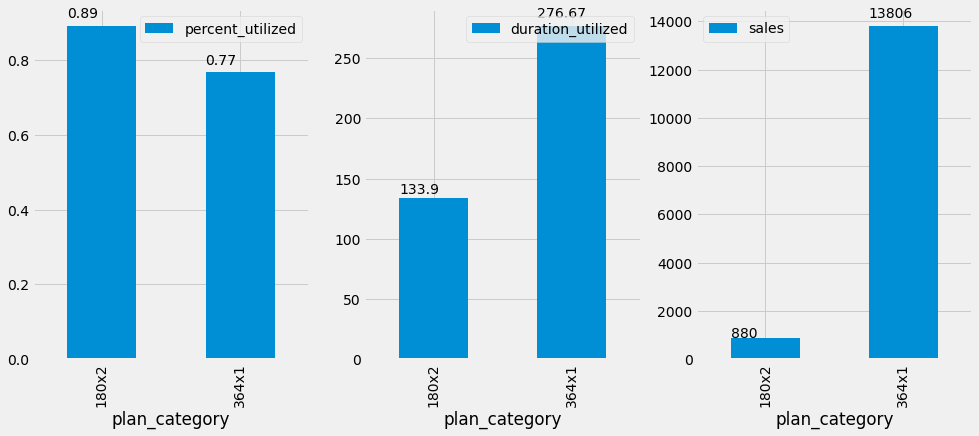

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

slice_df = model_df[model_df['plan_category'].isin(['180x2', '364x1'])]

slice_df.groupby(['plan_category']).mean()[['percent_utilized']].plot.bar(ax=ax[0])
slice_df.groupby(['plan_category']).mean()[['duration_utilized']].plot.bar(ax=ax[1])
slice_df.groupby(['plan_category']).size().reset_index(name='sales').plot.bar(x='plan_category', ax=ax[2])

for axs in ax:
    for p in axs.patches:
        axs.annotate(
            str(round(p.get_height(), 2)), 
            (p.get_x() * 1.00, 
             p.get_height() * 1.025)
        )
        


In [9]:
model_df.groupby(['plan_group']).size().reset_index(name='sales').set_index('plan_group')[['sales']]

,sales
plan_group,
90,33370
180,24452
364,14407


<AxesSubplot:xlabel='plan_category'>

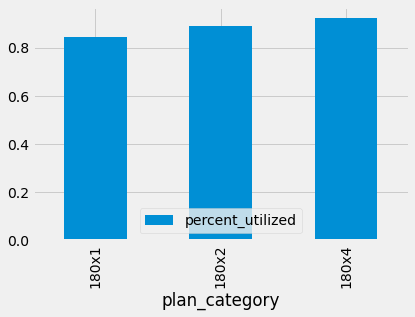

In [10]:
model_df[model_df['plan_category'].isin(['180x1', '180x2', '180x4'])]\
    .groupby(['plan_category']).mean()[['percent_utilized']].plot.bar()

In [11]:
model_df[model_df['plan_category'].isin(['180x1', '180x2', '180x4'])]\
    .groupby(['plan_category']).size().reset_index(name='counts')

,plan_category,counts
0,180x1,37216
1,180x2,880
2,180x4,17966


<AxesSubplot:xlabel='plan_category_adj'>

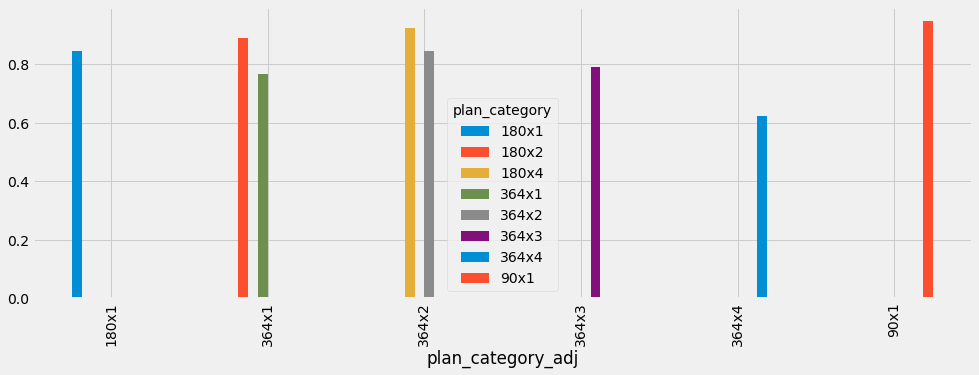

In [12]:
model_df.groupby(['plan_category_adj', 'plan_category']).mean()[['percent_utilized']].reset_index()\
    .pivot_table(index='plan_category_adj', columns='plan_category', values='percent_utilized')\
    .plot.bar(figsize=(15,5))

<ErrorbarContainer object of 3 artists>

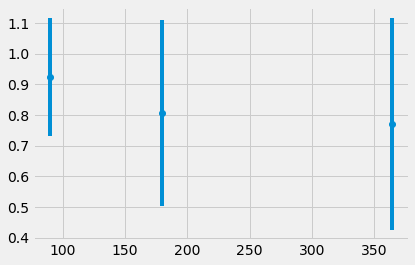

In [13]:
slice_df = model_df.groupby(['plan_group']).agg(['mean', 'std'])[['percent_utilized']]

slice_df = slice_df.percent_utilized.reset_index().set_index('plan_group')

plt.errorbar(x=slice_df.index, y=slice_df['mean'], yerr=slice_df['std'], fmt='o')

In [14]:
model_df.groupby(['plan_group']).mean()[['percent_utilized']]

,percent_utilized
plan_group,
90,0.9245
180,0.8066
364,0.7710


In [15]:
len(model_df[model_df['plan_category'] == '364x2'])

415

<AxesSubplot:xlabel='duration_utilized', ylabel='duration_sold'>

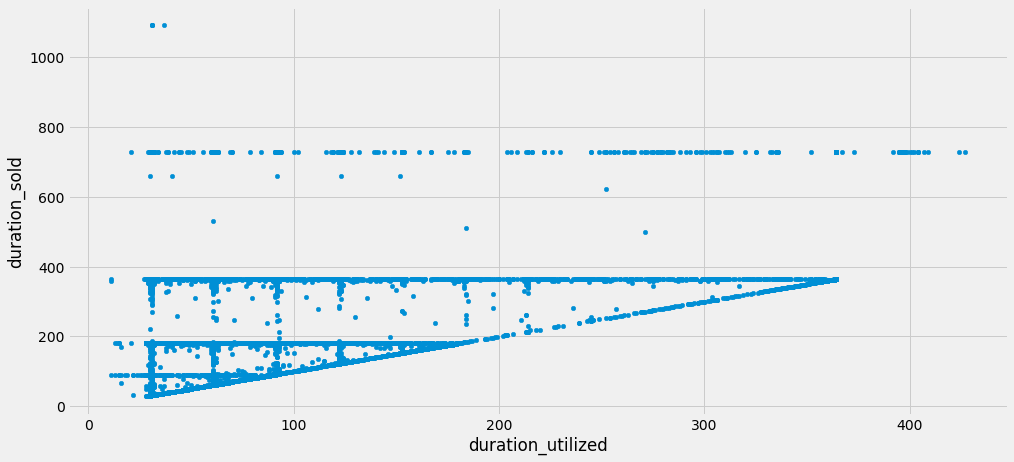

In [39]:
model_df[['duration_sold', 'duration_utilized']].plot.scatter(
    y='duration_sold', x='duration_utilized', figsize=(15,7)
)

In [17]:
slice_df = model_df.groupby(['plan_category']).size().reset_index(name='sales')
list(slice_df[slice_df['sales'] >= 200]['plan_category'])

['180x1', '180x2', '180x4', '364x1', '364x2', '90x1']

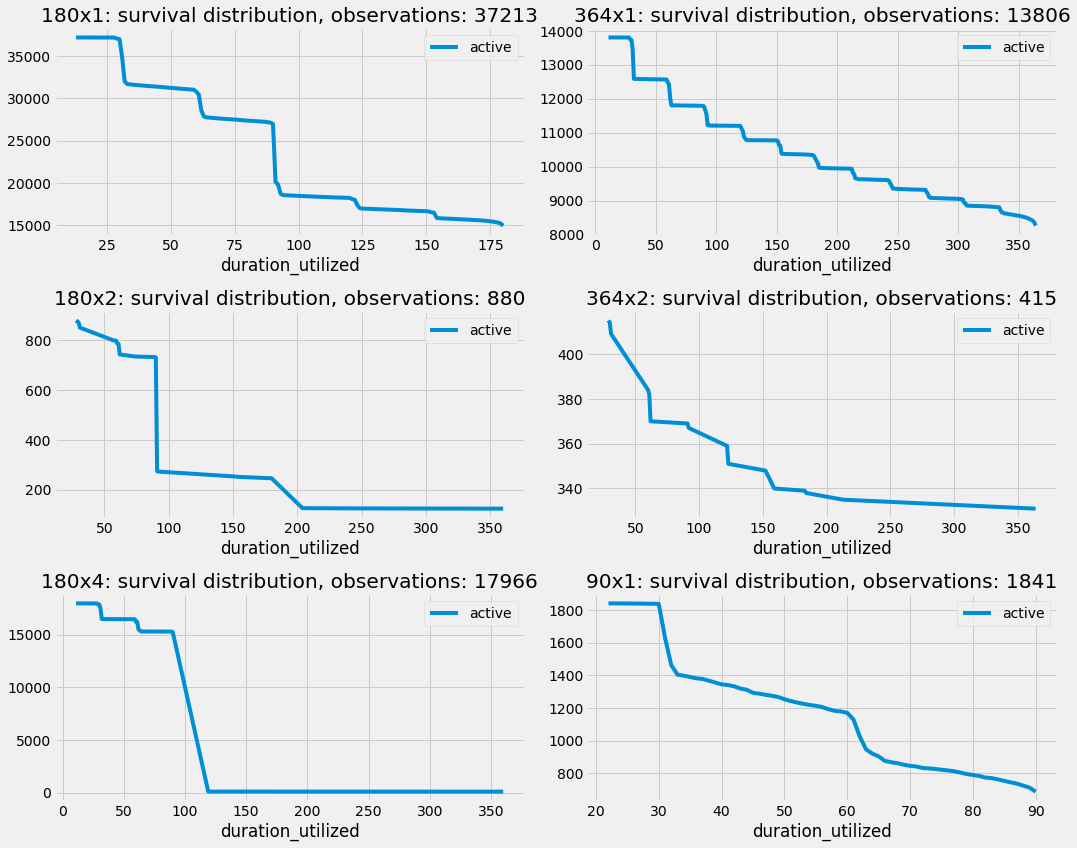

In [18]:
def plot_cumulative(df, category, ax, limit_days):

    df = df[df['duration_utilized'] <= limit_days]
    
    observations = len(df[df['plan_category'] == category])
    
    df[df['plan_category'] == category].groupby(['duration_utilized']).size().reset_index(name='active')\
        .sort_values(by='duration_utilized', ascending=False).set_index('duration_utilized')[['active']].cumsum()\
    .plot(ax=ax, title=f'{category}: survival distribution, observations: {observations}')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

plot_cumulative(df=model_df, category='180x1', ax=ax[0][0], limit_days=180)
plot_cumulative(df=model_df, category='180x2', ax=ax[1][0], limit_days=364)
plot_cumulative(df=model_df, category='180x4', ax=ax[2][0], limit_days=730)
plot_cumulative(df=model_df, category='364x1', ax=ax[0][1], limit_days=365)
plot_cumulative(df=model_df, category='364x2', ax=ax[1][1], limit_days=730)
plot_cumulative(df=model_df, category='90x1', ax=ax[2][1], limit_days=90)

fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Active Policies by Days since Effective Date: 90x1 plans'}, xlabel='duration_utilized'>

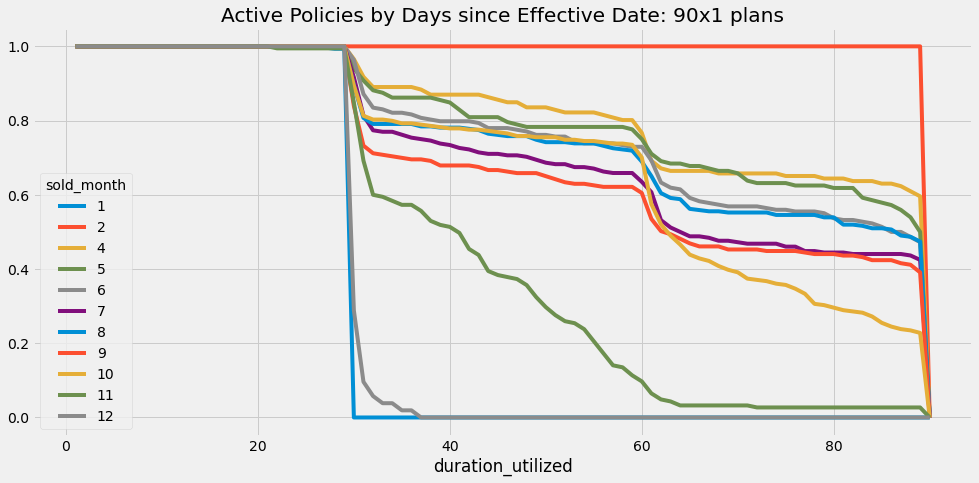

In [40]:
plan_category = '90x1'
duration_max = 90

base_df = model_df[(model_df['plan_category'] == plan_category) & (model_df['duration_utilized'] <= duration_max)]\
    .groupby(['sold_month','duration_utilized'])\
    .size().reset_index(name='active')

month_totals_df = base_df.groupby('sold_month').sum()[['active']].rename(columns={'active': 'total'}).reset_index()

dist_df = base_df.sort_values(by=['sold_month', 'duration_utilized'], ascending=True)


df_data =list()
for month in range(1, 13):
    for day in range(1, duration_max + 1):
        df_data.append([month, day])
        
alldays_df = pd.DataFrame(df_data, columns=['sold_month', 'duration_utilized'])
dist_df = dist_df.merge(alldays_df, on=['sold_month', 'duration_utilized'], how='right')

dist_df = dist_df.sort_values(by=['sold_month', 'duration_utilized'], ascending=True)\
    .groupby(['sold_month', 'duration_utilized'], sort=False).sum()\
    .groupby(level=0, sort=False).cumsum()[['active']].reset_index()
    
dist_df = dist_df.merge(month_totals_df)
dist_df['active'] = (dist_df['total'] - dist_df['active']) / dist_df['total']
dist_df.rename(columns={'active': 'percent_active'}, inplace=True)
dist_df.sort_values(by=['sold_month', 'duration_utilized'], inplace=True)

month_df = dist_df.pivot_table(index='duration_utilized', columns='sold_month', values='percent_active')
month_df.plot(figsize=(15,7), title=f'Active Policies by Days since Effective Date: {plan_category} plans')

In [41]:
month_df.head()

sold_month,1,2,4,5,6,7,8,9,10,11,12
duration_utilized,,,,,,,,,,,
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


/Users/trevor/venvs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='sold_year,sold_month'>

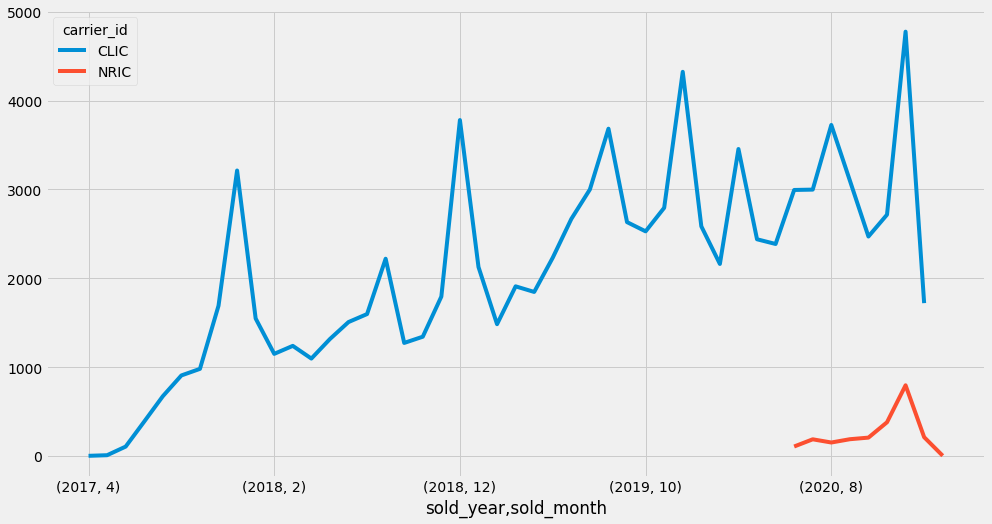

In [31]:
stm_df.groupby(['sold_year', 'sold_month', 'carrier_id'])\
    .size().reset_index(name='policies')\
    .pivot_table(
        index=['sold_year', 'sold_month'],
        columns=['carrier_id'],
        values='policies'
    ).plot(figsize=(15,8))

<AxesSubplot:title={'center':'Duration Take Rate by Month (2020 Only)'}, xlabel='sold_month'>

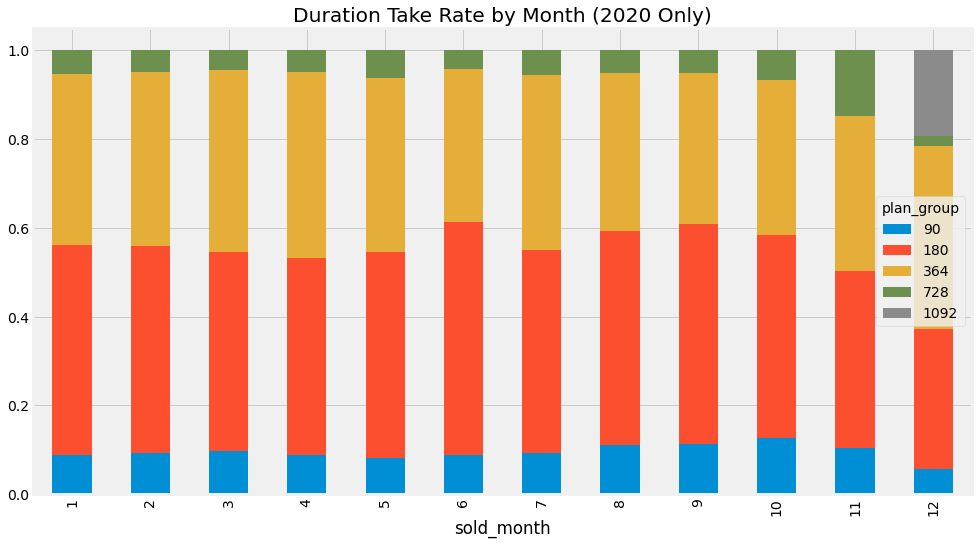

In [34]:
span_df = stm_df[stm_df['sold_year'] == 2020]

span_df = span_df.groupby(['sold_month', 'plan_group']).size().reset_index(name='policies')


span_df = span_df.groupby(['sold_month', 'plan_group']).sum() / span_df.groupby(['sold_month']).sum()[['policies']]

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='white')

span_df.pivot_table(
        index=['sold_month'],
        columns=['plan_group'],
        values='policies'
    ).plot.bar(stacked=True, figsize=(15,8), title='Duration Take Rate by Month (2020 Only)', ax=ax)



In [35]:
model_df = stm_df[stm_df['active'] == False].copy()

model_df['percent_utilized'] = model_df['duration_utilized'] / model_df['duration_sold']
model_df['duration_sold_est'] = round(model_df['duration_sold'], -1)
         
         
model_df.head()

,app_pid,sold_date,sold_year,sold_month,carrier_id,plan_category,plan_category_adj,plan_span,plan_group,duration_sold,duration_utilized,active,past_expiration,has_dental,has_vision,has_supp,state,plan_members,primary_age,has_children,child_age_average,percent_utilized,duration_sold_est
0,211996,2019-06-30,2019,6,CLIC,180x1,180x1,180,180,180,123,False,True,1,1,0,IN,4,30.0300,1,5.1600,0.6833,180
1,252434,2020-02-29,2020,2,CLIC,364x1,364x1,364,364,364,344,False,False,1,1,0,OH,1,36.9200,0,nan,0.9451,360
4,233991,2019-11-26,2019,11,CLIC,364x1,364x1,364,364,364,364,False,True,1,1,0,GA,1,39.3000,0,nan,1.0000,360
8,307304,2020-06-22,2020,6,CLIC,90x1,90x1,90,90,90,90,False,True,1,1,0,OR,1,41.0500,0,nan,1.0000,90
13,317871,2020-09-02,2020,9,CLIC,364x2,364x2,364,728,728,31,False,False,0,0,1,TX,2,55.3200,0,nan,0.0426,730


<AxesSubplot:xlabel='duration_sold_est'>

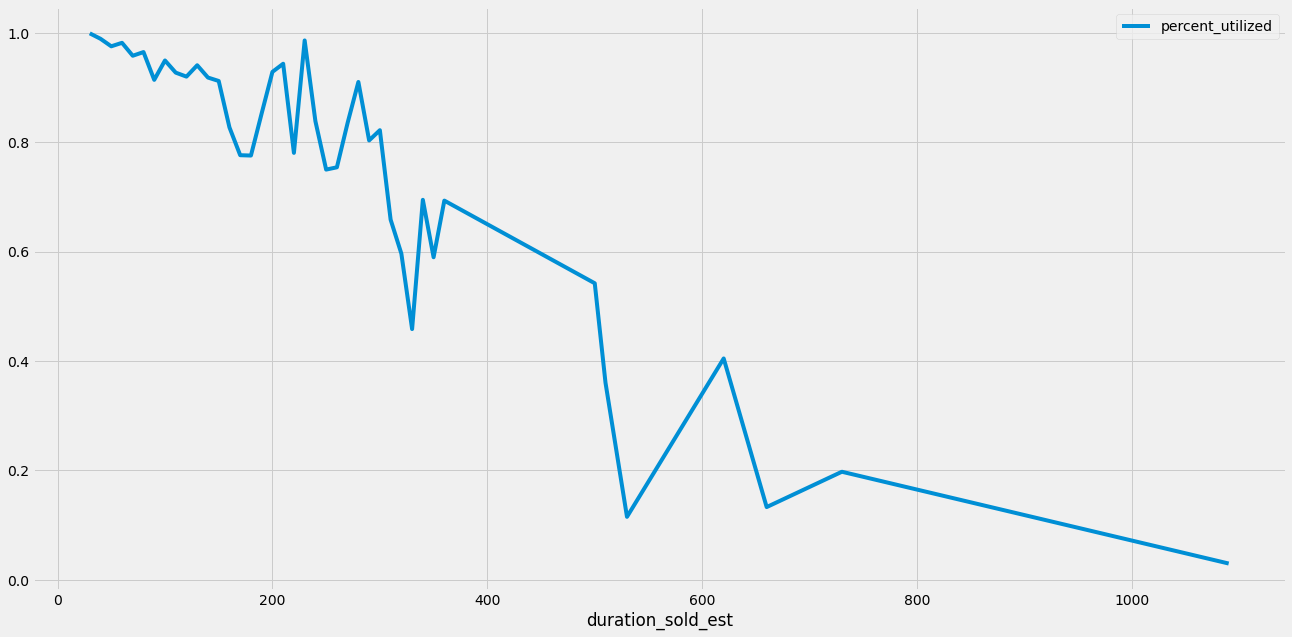

In [36]:
model_df.groupby(['duration_sold_est']).mean()[['percent_utilized']].plot(figsize=(20,10))